## Overview

Can you use this data set to make an algorithm able to determine if an article is fake news or not ?

## Data Description

Fake.csv file contains a list of articles considered as "fake" news. True.csv contains a list of articles considered as "real" news. Both the files contain 
1. The title of the article
2. The text of the article
3. The subject of the article
4. The date that this article was posted at

You can find the dataset [here](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).

## Files

* Fake.csv
* True.csv

## So let’s begin here…

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from string import punctuation

#import re,string,unicodedata

import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Using TensorFlow backend.


/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/fake-and-real-news-dataset/True.csv


## Load Data

In [2]:
real = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
fake = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")

In [3]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


## Pre-process Data

### Let's add another column in data set as category where category will be 1 if news is real and 0 if news is fake.

In [5]:
real['category']=1
fake['category']=0

### Now we will concatenate both the datasets

In [6]:
df = pd.concat([real,fake])

In [7]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


### Check for NULL values

In [8]:
df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

### Total number of news

In [9]:
df.title.count()

44898

### Number of news grouped by Subject

In [10]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

### We now concatenate Text, Title and Subject in Text.

In [11]:
df['text'] = df['text'] + " " + df['title'] + " " + df['subject']
del df['title']
del df['subject']
del df['date']

In [12]:
df.head()

,text,category
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [13]:
stop = set(stopwords.words('english'))
pnc = list(punctuation)
stop.update(pnc)

In [14]:
stemmer = PorterStemmer()
def stem_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text)

In [15]:
df.text = df.text.apply(stem_text)

### Splitting dataset in train set and test set

In [16]:
X_train,X_test,y_train,y_test = train_test_split(df.text,df.category)

In [17]:
cv = CountVectorizer(min_df=0,max_df=1,ngram_range=(1,2))

#transformed train reviews
cv_train = cv.fit_transform(X_train)
#transformed test reviews
cv_test = cv.transform(X_test)

print('BOW_cv_train:',cv_train.shape)
print('BOW_cv_test:',cv_test.shape)

BOW_cv_train: (33673, 1950850)
BOW_cv_test: (11225, 1950850)


## Defining Model

In [18]:
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = cv_train.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))

## Compile Model

In [19]:
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

## Fit Model

In [20]:
model.fit(cv_train,y_train , epochs = 5)

Epoch 1/5
33673/33673 [==============================] - 542s 16ms/step - loss: 0.6904 - accuracy: 0.5224
Epoch 2/5
33673/33673 [==============================] - 559s 17ms/step - loss: 0.1654 - accuracy: 0.9452
Epoch 3/5
33673/33673 [==============================] - 571s 17ms/step - loss: 0.0428 - accuracy: 0.9885
Epoch 4/5
33673/33673 [==============================] - 575s 17ms/step - loss: 0.0414 - accuracy: 0.9888
Epoch 5/5
33673/33673 [==============================] - 568s 17ms/step - loss: 0.0418 - accuracy: 0.9888


## Prediction

In [21]:
pred = model.predict(cv_test)
for i in range(len(pred)):
    if(pred[i] > 0.5):
        pred[i] = 1
    else:
        pred[i] = 0

## Evaluate Model

### Accuracy

In [22]:
accuracy_score(pred,y_test)

0.90271714922049

### Classification Report

In [23]:
cv_report = classification_report(y_test,pred,target_names = ['0','1'])
print(cv_report)

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      5929
           1       0.88      0.91      0.90      5296

    accuracy                           0.90     11225
   macro avg       0.90      0.90      0.90     11225
weighted avg       0.90      0.90      0.90     11225



### Confusion Matrix

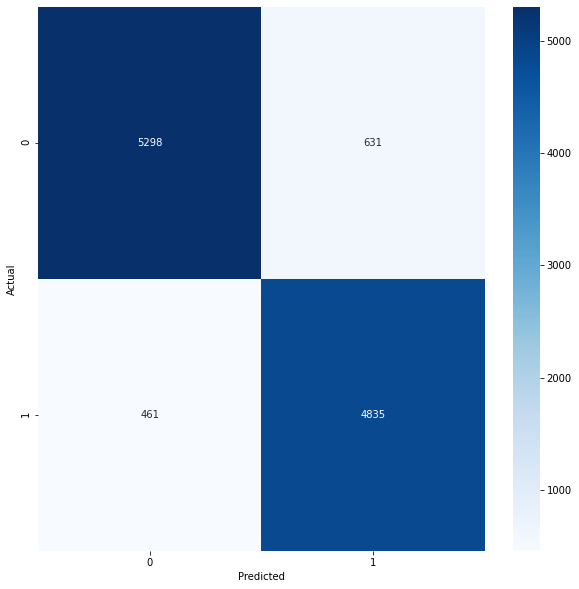

In [24]:
cm_cv = confusion_matrix(y_test,pred)
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')